In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

!pip install pandas_ta
import pandas_ta as ta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=7009ac20d73618d5f4db8c9f033daabe04462b05bda1df58f7ee102c598a1d14
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
from torch.utils.data.datapipes.datapipe import T
import torch
from torch import nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random

from datetime import datetime

from tqdm.auto import tqdm
from timeit import default_timer as timer

print(f"torch: {torch.__version__}")

torch: 2.1.0+cu118


In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score , mean_absolute_percentage_error

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Getting the dataset from `yfinance`

In [5]:
# taget stock : 'WBD'
# time period : from 1 Jan 2010 to 30 June 2023

In [6]:
data = yf.download(tickers = 'WBD', start = '2010-01-01',end = '2023-06-30')
data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.697496,15.968319,15.682167,15.840572,15.840572,2844108
2010-01-05,15.896781,16.535515,15.840572,16.463976,16.463976,3193041
2010-01-06,16.607052,16.760347,16.402657,16.709249,16.709249,3873099
2010-01-07,16.678591,16.852325,16.622381,16.699030,16.699030,2506526
2010-01-08,16.653040,16.842106,16.586613,16.750128,16.750128,2448598
2010-01-11,16.785896,16.842106,16.612162,16.693918,16.693918,2361512
2010-01-12,16.658150,16.683701,16.234032,16.249361,16.249361,2803598
2010-01-13,16.223812,16.402657,15.988758,16.346449,16.346449,2359164
2010-01-14,16.228922,16.484415,16.177822,16.213593,16.213593,1634291


In [7]:
data.count()

Open         3395
High         3395
Low          3395
Close        3395
Adj Close    3395
Volume       3395
dtype: int64

### 2. Adding finanical indicator to the dataset

In [8]:
data_1 = data.copy()

In [9]:
import math

In [10]:
# RSI : relative strength index (RSI) measures the price momentum of a stock
# EMA : exponential moving average (EMA) is a technical chart indicator
#.      that tracks the price of an investment over time.

In [11]:
# Target :  log(Adj close)[t+1] - log(Adj close[t]) *100

In [12]:
# Adding indicators
data_1['RSI']=ta.rsi(data_1.Close, length=15)
data_1['EMAF']=ta.ema(data_1.Close, length=20)
data_1['EMAM']=ta.ema(data_1.Close, length=100)
data_1['EMAS']=ta.ema(data_1.Close, length=150)

Targetlog = []
for i in data_1['Adj Close']:
  Targetlog.append(math.log(i))

data_1['logClose'] = Targetlog

data_1['Target'] = (data_1['logClose'].shift(-1)-data_1['logClose'])*100
#data_1['Target'] = data_1['Target'].shift(-1)

data_1['TargetClass'] = [1 if data_1.Target[i]>0 else 0 for i in range(len(data_1))]

data_1['TargetNextClose'] = data_1['Adj Close'].shift(-1)



#data_1['Targetlog'] = Targetlog


data_1.dropna(inplace=True)
#data.reset_index(inplace = True)
data_1.drop(['Volume', 'Close','logClose'], axis=1, inplace=True)

data_1.head(5)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,
2010-08-06,19.376596,19.565662,19.294840,19.514563,55.420541,19.217253,18.327305,17.729620,0.078532,1,19.529894
2010-08-09,19.560553,19.560553,19.417477,19.529894,55.608203,19.247028,18.351119,17.753465,0.911580,1,19.708738
2010-08-10,19.422586,19.754726,19.320389,19.708738,57.827089,19.291000,18.378002,17.779362,-1.673246,0,19.381706
2010-08-11,19.417477,19.453245,19.156874,19.381706,52.669252,19.299639,18.397878,17.800586,-1.514172,0,19.090445
2010-08-12,19.161983,19.274401,18.937149,19.090445,48.538064,19.279716,18.411592,17.817670,-0.429189,0,19.008686


In [13]:
len(data_1)

3245

<function matplotlib.pyplot.show(close=None, block=None)>

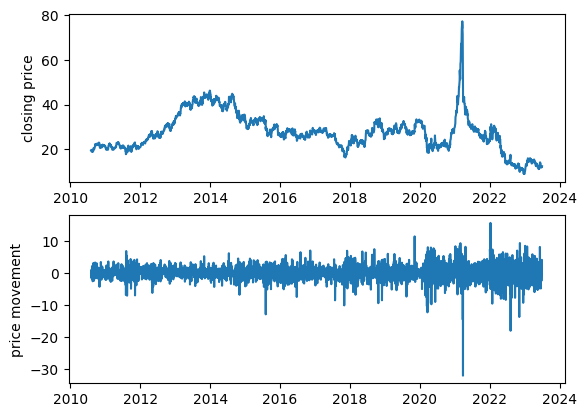

In [14]:
plt.subplot(2,1,1)
plt.plot(data_1.index, data_1["TargetNextClose"])
plt.ylabel("closing price")

plt.subplot(2,1,2)
plt.plot(data_1.index, data_1["Target"])
plt.ylabel("price movement")


plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

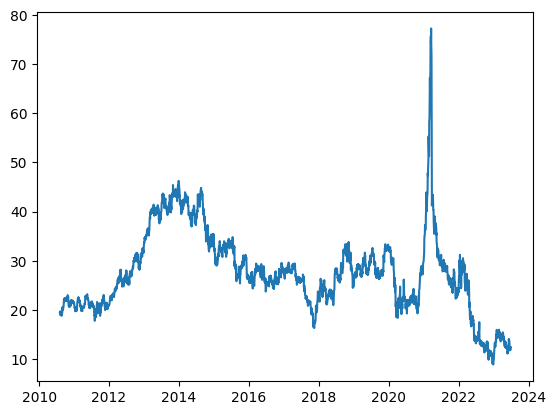

In [15]:
plt.plot(data_1.index, data_1["TargetNextClose"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

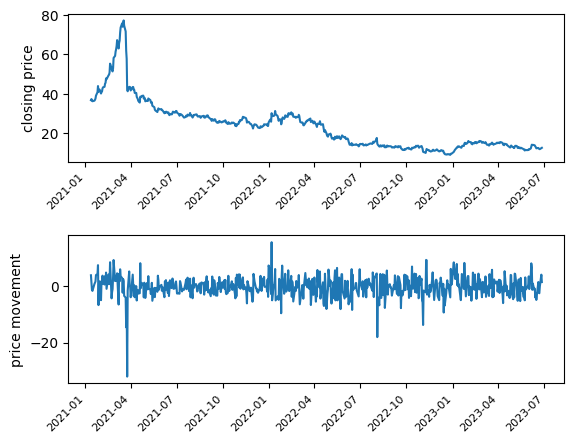

In [16]:
plt.subplot(2,1,1)
plt.plot(data_1.index[-619:-1], data_1["TargetNextClose"][-619:-1])
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.ylabel("closing price")

plt.subplot(2,1,2)
plt.plot(data_1.index[-619:-1], data_1["Target"][-619:-1])
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.ylabel("price movement")

plt.subplots_adjust(hspace= 0.5)
plt.show

In [17]:
data_fi = data_1.iloc[:,:]
print(f"data_1 shape: {data_1.shape}")
print(f"data_fi shape: {data_fi.shape}")
print(f"data_fi type: {type(data_fi)}")

data_1 shape: (3245, 11)
data_fi shape: (3245, 11)
data_fi type: <class 'pandas.core.frame.DataFrame'>


### 3. Preprocssing the dataset into dataset and dataloader

In [18]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler



scaler = MinMaxScaler()
data_fi_scl = scaler.fit_transform(data_fi)

print(data_fi_scl)
print(f"data_fi_scl shape: {data_fi_scl.shape}")


[[0.15042905 0.14986448 0.15945867 ... 0.67459545 1.         0.15584641]
 [0.15309586 0.14979032 0.16132557 ... 0.6920684  1.         0.1584611 ]
 [0.15109577 0.15260852 0.1598476  ... 0.63785234 0.         0.15367992]
 ...
 [0.0404465  0.04005806 0.04232    ... 0.758429   1.         0.04970761]
 [0.04102638 0.04644412 0.04506013 ... 0.70349442 1.         0.05233918]
 [0.04740505 0.04731495 0.05038819 ... 0.66788804 0.         0.05190059]]
data_fi_scl shape: (3245, 11)


In [19]:
print(data_fi_scl.shape[0])

3245


In [20]:
#data_fi_scl = data_fi.copy()
#data_fi_scl = np.array(data_fi_scl)
#data_fi_scl

### Backcandles parameters (timestep)

In [21]:
X = []
backcandles = 30
for j in range(8):
  X.append([])
  for i in range(backcandles, data_fi_scl.shape[0]):
    X[j].append(data_fi_scl[i-backcandles:i,j])

X_10 = np.moveaxis(X, [0], [2])
print(f"X_10 len:{len(X_10)}")


X_10 len:3215


In [22]:
X_10.shape

(3215, 30, 8)

In [23]:
X_10 , yi = np.array(X_10), np.array(data_fi_scl[backcandles:,-3]) #get "Target" col[-3]
y_10 = np.reshape(yi, (len(yi),1))

print(f"X_10 shape: {X_10.shape}")
print(f"y_10 shape: {y_10.shape}")

X_10 shape: (3215, 30, 8)
y_10 shape: (3215, 1)


In [24]:
#split train & valid & test set

split_ratio = 0.7
split_ind = int((X_10.shape[0]) * split_ratio)
print(f"split_ind: {split_ind}")
split_ratio = 0.85
split_ind2 = int((X_10.shape[0]) * split_ratio)
print(f"split_ind: {split_ind2}")

X_10_train, X_10_val, X_10_test = X_10[:split_ind], X_10[split_ind:split_ind2] , X_10[split_ind2:]
y_10_train, y_10_val, y_10_test = y_10[:split_ind], y_10[split_ind:split_ind2], y_10[split_ind2:]

print(f"input shape for training set (10 backcandles): {X_10_train.shape}")
print(f"input shape for validation set (10 backcandles): {X_10_val.shape}")
print(f"input shape for testing set (10 backcandles): {X_10_test.shape}")
print(f"output shape for training set (10 backcandles): {y_10_train.shape}")
print(f"output shape for validation set (10 backcandles): {y_10_val.shape}")
print(f"output shape for testing set (10 backcandles): {y_10_test.shape}")

split_ind: 2250
split_ind: 2732
input shape for training set (10 backcandles): (2250, 30, 8)
input shape for validation set (10 backcandles): (482, 30, 8)
input shape for testing set (10 backcandles): (483, 30, 8)
output shape for training set (10 backcandles): (2250, 1)
output shape for validation set (10 backcandles): (482, 1)
output shape for testing set (10 backcandles): (483, 1)


In [25]:
BATCH_SIZE = 64

train_set = TensorDataset(torch.Tensor(X_10_train), torch.Tensor(y_10_train))
val_set = TensorDataset(torch.Tensor(X_10_val), torch.Tensor(y_10_val))
test_set = TensorDataset(torch.Tensor(X_10_test), torch.Tensor(y_10_test))

train_dataloader = DataLoader(train_set,
                              batch_size = BATCH_SIZE,
                              shuffle = False)
val_dataloader = DataLoader(val_set,
                              batch_size = BATCH_SIZE,
                              shuffle = False)
test_dataloader = DataLoader(test_set,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

In [26]:
train_dataloader

In [27]:
test_dataloader

### 4. building baseline vanilla RNN

In [28]:
class RNNv0(nn.Module):
  def __init__(self,
               input_dim,
               hidden_dim,
               layer_dim = 1,
               output_dim = 1,
               dropout_prob = 0):

    super().__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    self.rnn = nn.RNN(input_size = input_dim,
                      hidden_size = hidden_dim,
                      num_layers = layer_dim,
                      batch_first = True,
                      dropout = dropout_prob)
    self.fc = nn.Linear(in_features = hidden_dim,
                        out_features = output_dim)

  def forward(self, X):
    h0 = torch.zeros(self.layer_dim,
                     X.size(0),
                     self.hidden_dim,
                     device = X.device).requires_grad_()

    output, h0 = self.rnn(X, h0.detach())
    output = output[:, -1, :]
    output = self.fc(output)

    return output

# baseline parameters

In [29]:
#baseline param
input_dim_bl = 8
hidden_dim_bl = 16
layer_dim_bl = 2
output_dim_bl = 1
dropout_prob_bl = 0.2

lr_bl = 1e-4
wd_bl = 1e-4

epochs_bl = 10

### train & test

In [30]:
torch.manual_seed(318)
torch.cuda.manual_seed(318)
RNN_model = RNNv0(input_dim = input_dim_bl,
                  hidden_dim = hidden_dim_bl,
                  layer_dim = layer_dim_bl,
                  output_dim = output_dim_bl,
                  dropout_prob = dropout_prob_bl)
RNN_model

RNNv0(
  (rnn): RNN(8, 16, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [31]:

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = RNN_model.parameters(),
                             lr = lr_bl,
                             weight_decay = wd_bl)

In [32]:
epochs = epochs_bl

RNN_model.to(device)

Epochs = []
TrainLoss = []
ValLoss = []
#Pred = []
Train = []


for epoch in tqdm(range(epochs)):

  train_loss = 0
  RNN_model.train()

  for batch, (X_train,y_train) in enumerate(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    #1. pass
    y_pred = RNN_model(X_train)

    #2. calculate loss
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    #Train.append([y_pred, y_train])

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. loss backward
    loss.backward()

    #5. optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)



  #validation
  val_loss = 0
  RNN_model.eval()
  with torch.no_grad():
    for X_val, y_val in val_dataloader:
      X_val, y_val = X_val.to(device), y_val.to(device)

      val_pred = RNN_model(X_val)

      val_loss += loss_fn(val_pred,y_val)

      #if epoch == (epochs-1):
        #Pred.append(val_pred.to("cpu"))

    val_loss /= len(val_dataloader)

  if epoch ==0 or (epoch+1) % 5 == 0:
    print(f"{epoch+1}/{epochs}: train loss: {train_loss:.4f} | validation loss: {val_loss:.4f}")

  Epochs.append(epoch)
  if device == "cpu":
    TrainLoss.append(train_loss.detach().numpy())
    ValLoss.append(val_loss)

  else:
    TrainLoss.append(train_loss.to("cpu").detach().numpy())
    ValLoss.append(val_loss.to("cpu").detach().numpy())


  0%|          | 0/10 [00:00<?, ?it/s]

1/10: train loss: 0.6603 | validation loss: 0.5589
5/10: train loss: 0.0661 | validation loss: 0.0311
10/10: train loss: 0.0108 | validation loss: 0.0061


In [33]:
RNNv0_loss = [TrainLoss, ValLoss]

<function matplotlib.pyplot.show(close=None, block=None)>

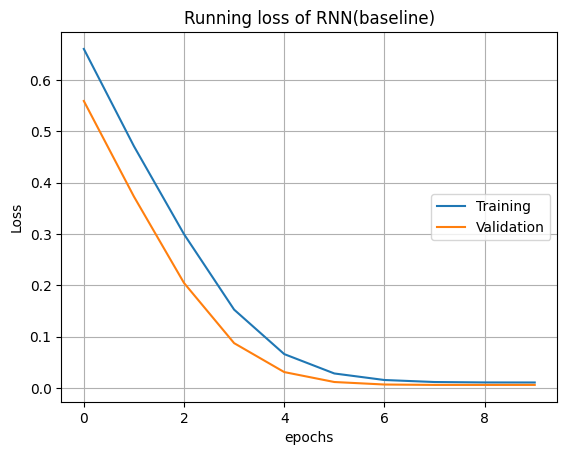

In [34]:
plt.subplot(1,1,1)
plt.plot(Epochs, TrainLoss , label="Training")
plt.plot(Epochs, ValLoss, label = "Validation")
plt.legend(loc='right')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Running loss of RNN(baseline)")
plt.grid(True)

plt.show

In [35]:
RNN_trainv1 = {'model':RNN_model.__class__.__name__,
                'Epochs': epochs_bl,
                'val_loss(train)':ValLoss[-1].item(),
                'epoch':ValLoss.index(min(ValLoss)),
                'val_loss':min(ValLoss).item()}
RNN_trainv1

{'model': 'RNNv0',
 'Epochs': 10,
 'val_loss(train)': 0.006080253049731255,
 'epoch': 8,
 'val_loss': 0.006048925686627626}

In [36]:
# Evaluation
Pred = []

test_loss = 0
RNN_model.eval()
with torch.no_grad():
  for X_test, y_test in test_dataloader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    test_pred = RNN_model(X_test)

    test_loss += loss_fn(test_pred,y_test)

    if epoch == (epochs-1):
      Pred.append(test_pred.to("cpu"))

  test_loss /= len(test_dataloader)

print(f" test loss: {test_loss:.4f}")


 test loss: 0.0115


In [37]:
convertPred = []
for i in Pred:
  for ii in i:
    convertPred.append(ii.item())

convertTrue = []
for i in y_10_test.tolist():
  convertTrue.append(i[0])

print(len(convertTrue))
print(len(convertPred))

483
483


In [38]:
convertTrueList = []
for i in range(len(convertTrue)):
  convertTrueList.append([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,convertTrue[i],0.5,0.5])

print(len(convertTrueList))

a_t = scaler.inverse_transform(np.array(convertTrueList))

convertPredList = []
for i in range(len(convertTrue)):
  convertPredList.append([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,convertPred[i],0.5,0.5])

print(len(convertPredList))

a_p = scaler.inverse_transform(np.array(convertPredList))


convertTrueList_SB = []
for i in (a_t.tolist()):
  convertTrueList_SB.append(i[-3])

convertPredList_SB = []
for i in (a_p.tolist()):
  convertPredList_SB.append(i[-3])

483
483


In [39]:
#print(f"mean absolute error: {mean_absolute_error(convertTrue, convertPred)}")
#print(f"root mean squared error: {root_mean_squared_error(convertTrue, convertPred)}")
#print(f"mean absolute percentage error: {mean_absolute_percentage_error(convertTrue, convertPred)}")

RNN_resultv0 = {'model':RNN_model.__class__.__name__,
                'mean_absolute_error':mean_absolute_error(convertTrueList_SB, convertPredList_SB),
                'root_mean_squared_error':mean_squared_error(convertTrueList_SB, convertPredList_SB)**0.5,}

RNN_resultv0_list = [convertTrue, convertPred]
RNN_resultv0

{'model': 'RNNv0',
 'mean_absolute_error': 3.9870743057162077,
 'root_mean_squared_error': 5.012937595728408}

<function matplotlib.pyplot.show(close=None, block=None)>

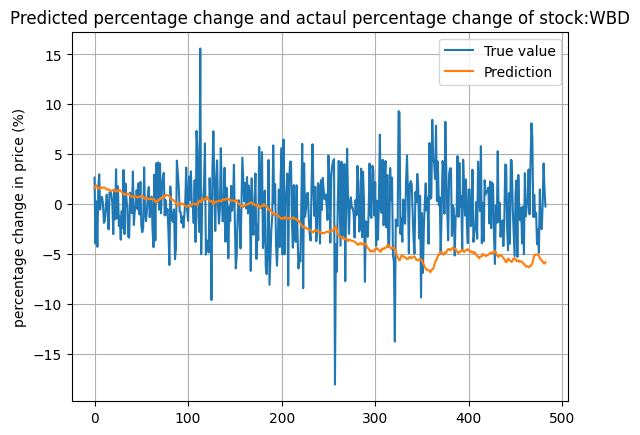

In [40]:
plt.subplot(1,1,1)
plt.title("Predicted percentage change and actaul percentage change of stock:WBD")
plt.plot(convertTrueList_SB, label="True value")
plt.plot(convertPredList_SB, label="Prediction")
plt.legend(loc='upper right')
plt.ylabel("percentage change in price (%)")
plt.grid(True)
plt.show

In [41]:
#y_true = inverse_transform(scaler, convertTrue)

In [42]:
for X, y in train_dataloader:
  print(X.shape)
  print(X.view([32,-1,1]).shape)
  break

torch.Size([64, 30, 8])
torch.Size([32, 480, 1])


In [43]:
## need to study this

def inverse_transform(scaler, df, columns):
  for col in columns:
    df[col] = scaler.inverse_transform(df[col])

  return df



## LSTM class:

In [44]:
class LSTMv0(nn.Module):
  def __init__(self, input_dim,
                      hidden_dim,
                      layer_dim = 1,
                      output_dim = 1,
                      dropout_prob = 0):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    self.LSTM = nn.LSTM(input_size = input_dim,
                        hidden_size = hidden_dim,
                        num_layers = layer_dim,
                        batch_first = True,
                        dropout = dropout_prob)

    self.fc = nn.Linear(in_features = hidden_dim,
                        out_features = output_dim)

  def forward(self, X):
    h0 = torch.zeros(self.layer_dim,
                     X.size(0),
                     self.hidden_dim,
                     device = X.device).requires_grad_()

    c0 = torch.zeros(self.layer_dim,
                     X.size(0),
                     self.hidden_dim,
                     device = X.device).requires_grad_()


    out, (hn , cn) = self.LSTM(X, (h0.detach(), c0.detach()))
    out = out[:,-1,:]
    out = self.fc(out)

    return out


## Gated Recurrent Unit (GRU) class

In [45]:
class GRUv0(nn.Module):
  def __init__(self, input_dim,
                      hidden_dim,
                      layer_dim = 1,
                      output_dim = 1,
                      dropout_prob = 0):
    super().__init__()

    self.layer_dim = layer_dim
    self.hidden_dim = hidden_dim

    self.GRU = nn.GRU(input_size = input_dim,
                      hidden_size = hidden_dim,
                      num_layers = layer_dim,
                      batch_first = True,
                      dropout = dropout_prob)
    self.fc = nn.Linear(in_features = hidden_dim,
                        out_features = output_dim)

  def forward(self, X):
    h0 = torch.zeros(self.layer_dim,
                     X.size(0),
                     self.hidden_dim,
                     device = X.device).requires_grad_()

    out , _ = self.GRU(X, h0.detach())
    out = out[:,-1,:]
    out = self.fc(out)

    return out

## LSTM baseline model

In [46]:
torch.manual_seed(318)
torch.cuda.manual_seed(318)
LSTM_model = LSTMv0(input_dim = input_dim_bl,
                  hidden_dim = hidden_dim_bl,
                  layer_dim = layer_dim_bl,
                  output_dim = output_dim_bl,
                  dropout_prob = dropout_prob_bl)
LSTM_model

LSTMv0(
  (LSTM): LSTM(8, 16, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [47]:

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = LSTM_model.parameters(),
                             lr = lr_bl,
                             weight_decay = wd_bl)

In [48]:
epochs = epochs_bl

LSTM_model.to(device)

Epochs = []
TrainLoss = []
ValLoss = []
Pred = []
Train = []


for epoch in tqdm(range(epochs)):

  train_loss = 0
  LSTM_model.train()

  for batch, (X_train,y_train) in enumerate(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    #1. pass
    y_pred = LSTM_model(X_train)

    #2. calculate loss
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    #Train.append([y_pred, y_train])

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. loss backward
    loss.backward()

    #5. optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)



  #validation
  val_loss = 0
  LSTM_model.eval()
  with torch.no_grad():
    for X_val, y_val in val_dataloader:
      X_val, y_val = X_val.to(device), y_val.to(device)

      val_pred = LSTM_model(X_val)

      val_loss += loss_fn(val_pred,y_val)

      #if epoch == (epochs-1):
        #Pred.append(val_pred.to("cpu"))

    val_loss /= len(val_dataloader)

  if epoch ==0 or (epoch+1) % 5 == 0:
    print(f"{epoch+1}/{epochs}: train loss: {train_loss:.4f} | validation loss: {val_loss:.4f}")

  Epochs.append(epoch)
  if device == "cpu":
    TrainLoss.append(train_loss.detach().numpy())
    ValLoss.append(val_loss)

  else:
    TrainLoss.append(train_loss.to("cpu").detach().numpy())
    ValLoss.append(val_loss.to("cpu").detach().numpy())


  0%|          | 0/10 [00:00<?, ?it/s]

1/10: train loss: 0.1996 | validation loss: 0.1855
5/10: train loss: 0.0700 | validation loss: 0.0569
10/10: train loss: 0.0025 | validation loss: 0.0053


<function matplotlib.pyplot.show(close=None, block=None)>

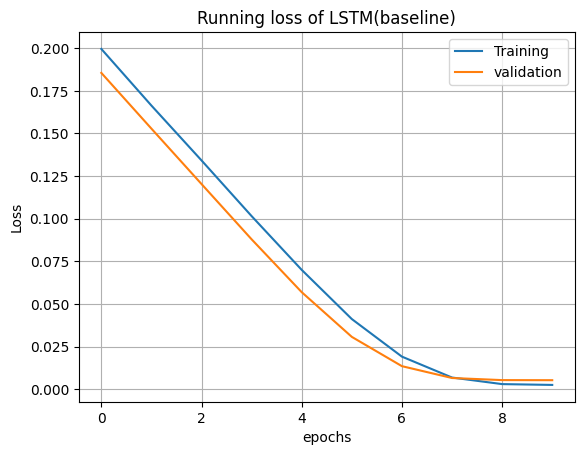

In [49]:
plt.subplot(1,1,1)
plt.plot(Epochs, TrainLoss , label="Training")
plt.plot(Epochs, ValLoss, label = "validation")
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Running loss of LSTM(baseline)")
plt.grid(True)

plt.show

In [50]:
LSTM_trainv1 = {'model':LSTM_model.__class__.__name__,
                'Epochs': epochs_bl,
                'val_loss(train)':ValLoss[-1].item(),
                'epoch':ValLoss.index(min(ValLoss)),
                'val_loss':min(ValLoss).item()}
LSTM_trainv1

{'model': 'LSTMv0',
 'Epochs': 10,
 'val_loss(train)': 0.005318715237081051,
 'epoch': 9,
 'val_loss': 0.005318715237081051}

In [51]:
# Evaluation
Pred = []

test_loss = 0
LSTM_model.eval()
with torch.no_grad():
  for X_test, y_test in test_dataloader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    test_pred = LSTM_model(X_test)

    test_loss += loss_fn(test_pred,y_test)

    if epoch == (epochs-1):
      Pred.append(test_pred.to("cpu"))

  test_loss /= len(test_dataloader)

print(f" test loss: {test_loss:.4f}")


 test loss: 0.0076


In [52]:
convertPred = []
for i in Pred:
  for ii in i:
    convertPred.append(ii.item())


convertTrue = []
for i in y_10_test.tolist():
  convertTrue.append(i[0])


print(len(convertTrue))
print(len(convertPred))

483
483


In [53]:
convertTrueList = []
for i in range(len(convertTrue)):
  convertTrueList.append([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,convertTrue[i],0.5,0.5])

print(len(convertTrueList))

a_t = scaler.inverse_transform(np.array(convertTrueList))

convertPredList = []
for i in range(len(convertTrue)):
  convertPredList.append([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,convertPred[i],0.5,0.5])

print(len(convertPredList))

a_p = scaler.inverse_transform(np.array(convertPredList))


convertTrueList_SB = []
for i in (a_t.tolist()):
  convertTrueList_SB.append(i[-3])

convertPredList_SB = []
for i in (a_p.tolist()):
  convertPredList_SB.append(i[-3])

483
483


In [54]:
#print(f"mean absolute error: {mean_absolute_error(convertTrue, convertPred)}")
#print(f"mean squared error: {mean_squared_error(convertTrue, convertPred)**0.5}")
#print(f"R^2 score: {r2_score(convertTrue, convertPred)}")

LSTM_resultv0 = {'model':LSTM_model.__class__.__name__,
                'mean_absolute_error':mean_absolute_error(convertTrueList_SB, convertPredList_SB),
                'root_mean_squared_error':mean_squared_error(convertTrueList_SB, convertPredList_SB)**0.5,}

LSTM_resultv0_list = [convertTrue, convertPred]
LSTM_resultv0

{'model': 'LSTMv0',
 'mean_absolute_error': 3.2147312154795373,
 'root_mean_squared_error': 4.136680280054736}

<function matplotlib.pyplot.show(close=None, block=None)>

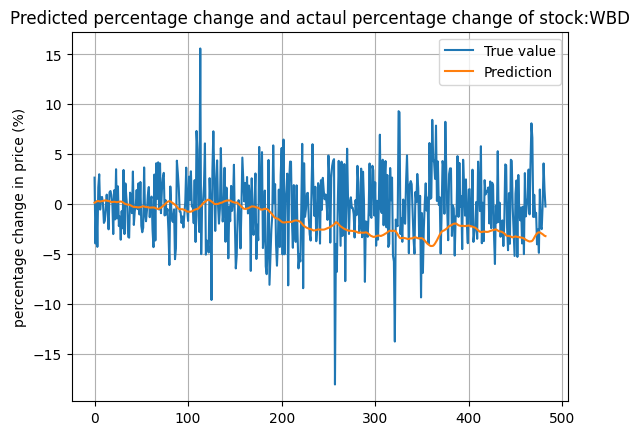

In [55]:
plt.subplot(1,1,1)
plt.title("Predicted percentage change and actaul percentage change of stock:WBD")
plt.plot(convertTrueList_SB, label="True value")
plt.plot(convertPredList_SB, label="Prediction")
plt.legend(loc='upper right')
plt.ylabel("percentage change in price (%)")
plt.grid(True)
plt.show

## GRU baseline model

In [56]:
torch.manual_seed(318)
torch.cuda.manual_seed(318)
GRU_model = GRUv0(input_dim = input_dim_bl,
                  hidden_dim = hidden_dim_bl,
                  layer_dim = layer_dim_bl,
                  output_dim = output_dim_bl,
                  dropout_prob = dropout_prob_bl)
GRU_model

GRUv0(
  (GRU): GRU(8, 16, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [57]:

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = GRU_model.parameters(),
                             lr = lr_bl,
                             weight_decay = wd_bl)

In [58]:
epochs = epochs_bl

GRU_model.to(device)

Epochs = []
TrainLoss = []
ValLoss = []
Pred = []
Train = []


for epoch in tqdm(range(epochs)):

  train_loss = 0
  GRU_model.train()

  for batch, (X_train,y_train) in enumerate(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    #1. pass
    y_pred = GRU_model(X_train)

    #2. calculate loss
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    #Train.append([y_pred, y_train])

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. loss backward
    loss.backward()

    #5. optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)



  #validation
  val_loss = 0
  GRU_model.eval()
  with torch.no_grad():
    for X_val, y_val in val_dataloader:
      X_val, y_val = X_val.to(device), y_val.to(device)

      val_pred = GRU_model(X_val)

      val_loss += loss_fn(val_pred,y_val)

      #if epoch == (epochs-1):
        #Pred.append(val_pred.to("cpu"))

    val_loss /= len(val_dataloader)

  if epoch ==0 or (epoch+1) % 5 == 0:
    print(f"{epoch+1}/{epochs}: train loss: {train_loss:.4f} | validation loss: {val_loss:.4f}")

  Epochs.append(epoch)
  if device == "cpu":
    TrainLoss.append(train_loss.detach().numpy())
    ValLoss.append(val_loss)

  else:
    TrainLoss.append(train_loss.to("cpu").detach().numpy())
    ValLoss.append(val_loss.to("cpu").detach().numpy())


  0%|          | 0/10 [00:00<?, ?it/s]

1/10: train loss: 0.4563 | validation loss: 0.4018
5/10: train loss: 0.1214 | validation loss: 0.0921
10/10: train loss: 0.0076 | validation loss: 0.0094


<function matplotlib.pyplot.show(close=None, block=None)>

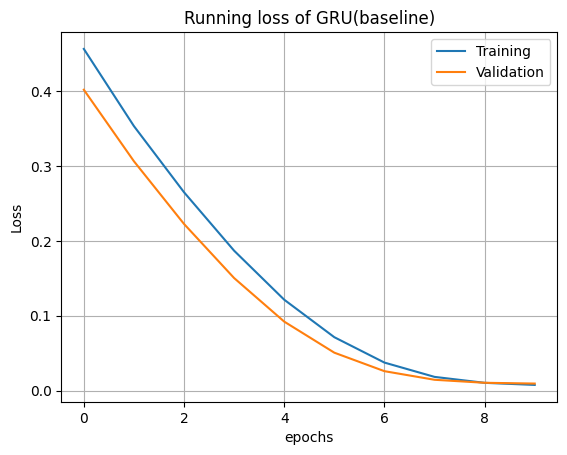

In [59]:
plt.subplot(1,1,1)
plt.plot(Epochs, TrainLoss , label="Training")
plt.plot(Epochs, ValLoss, label = "Validation")
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Running loss of GRU(baseline)")
plt.grid(True)

plt.show

In [60]:
GRU_trainv1 = {'model':GRU_model.__class__.__name__,
                'Epochs': epochs_bl,
                'val_loss(train)':ValLoss[-1].item(),
                'epoch':ValLoss.index(min(ValLoss)),
                'val_loss':min(ValLoss).item()}
GRU_trainv1

{'model': 'GRUv0',
 'Epochs': 10,
 'val_loss(train)': 0.009395190514624119,
 'epoch': 9,
 'val_loss': 0.009395190514624119}

In [61]:
# Evaluation
Pred = []

test_loss = 0
GRU_model.eval()
with torch.no_grad():
  for X_test, y_test in test_dataloader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    test_pred = GRU_model(X_test)

    test_loss += loss_fn(test_pred,y_test)

    if epoch == (epochs-1):
      Pred.append(test_pred.to("cpu"))

  test_loss /= len(test_dataloader)

print(f" test loss: {test_loss:.4f}")


 test loss: 0.0284


In [62]:
convertPred = []
for i in Pred:
  for ii in i:
    convertPred.append(ii.item())


convertTrue = []
for i in y_10_test.tolist():
  convertTrue.append(i[0])


print(len(convertTrue))
print(len(convertPred))

483
483


In [69]:
convertTrueList = []
for i in range(len(convertTrue)):
  convertTrueList.append([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,convertTrue[i],0.5,0.5])

print(len(convertTrueList))

a_t = scaler.inverse_transform(np.array(convertTrueList))

convertPredList = []
for i in range(len(convertTrue)):
  convertPredList.append([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,convertPred[i],0.5,0.5])

print(len(convertPredList))

a_p = scaler.inverse_transform(np.array(convertPredList))


convertTrueList_SB = []
for i in (a_t.tolist()):
  convertTrueList_SB.append(i[-3])

convertPredList_SB = []
for i in (a_p.tolist()):
  convertPredList_SB.append(i[-3])

483
483


In [70]:
#print(f"mean absolute error: {mean_absolute_error(convertTrue, convertPred)}")
#print(f"mean squared error: {mean_squared_error(convertTrue, convertPred)**0.5}")
#print(f"R^2 score: {r2_score(convertTrue, convertPred)}")


GRU_resultv0 = {'model':GRU_model.__class__.__name__,
                'mean_absolute_error':mean_absolute_error(convertTrueList_SB, convertPredList_SB),
                'root_mean_squared_error':mean_squared_error(convertTrueList_SB, convertPredList_SB)**0.5,}

GRU_resultv0_list = [convertTrue, convertPred]
GRU_resultv0

{'model': 'GRUv0',
 'mean_absolute_error': 6.375724261999779,
 'root_mean_squared_error': 7.848804796572164}

<function matplotlib.pyplot.show(close=None, block=None)>

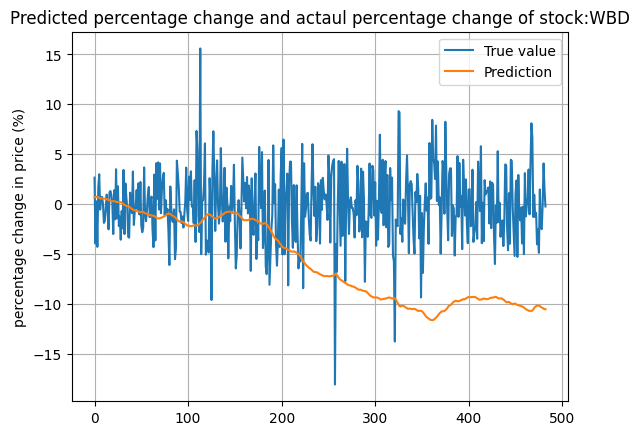

In [65]:
plt.subplot(1,1,1)
plt.title("Predicted percentage change and actaul percentage change of stock:WBD")
plt.plot(convertTrueList_SB, label="True value")
plt.plot(convertPredList_SB, label="Prediction")
plt.legend(loc='upper right')
plt.ylabel("percentage change in price (%)")
plt.grid(True)
plt.show

## Results

In [66]:
#

In [67]:
trainv1 = pd.DataFrame([RNN_trainv1,
                        LSTM_trainv1,
                        GRU_trainv1])
trainv1.style.format(precision=4, decimal=".")

,model,Epochs,val_loss(train),epoch,val_loss
0,RNNv0,10,0.0061,8,0.0060
1,LSTMv0,10,0.0053,9,0.0053
2,GRUv0,10,0.0094,9,0.0094


In [71]:
resultv0 = pd.DataFrame([RNN_resultv0,
                        LSTM_resultv0,
                        GRU_resultv0])
resultv0.style.format(precision=4, decimal=".")


,model,mean_absolute_error,root_mean_squared_error
0,RNNv0,3.9871,5.0129
1,LSTMv0,3.2147,4.1367
2,GRUv0,6.3757,7.8488
